In [151]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

In [152]:
#for replicability purposes
tf.random.set_seed(91195003)
np.random.seed(91195003)

#for an easy reset backend session state
tf.keras.backend.clear_session()

In [153]:
#load dataset
def load_dataset(path):
  return pd.read_csv(path)

In [154]:
#split data into training and validation sets
def split_data(training, perc=10):
  train_idx = np.arange(0,int(len(training)*(100-perc)/100))
  val_idx = np.arange(int(len(training)* (100-perc)/100+1),len(training))
  return train_idx, val_idx


In [155]:
#preparing the data for the LSTM
def prepare_data(df):
        #retirar a primeira row porque tem valores nulos
        df_raw = df.drop([0])
        #Get pair to evaluate for time series
        #We are going to predict the opening value for each day
        df_raw["Start Date"] = pd.to_datetime(df_raw["Start Date"])
        df_raw = df_raw.sort_values("Start Date")
        df_raw = df_raw.set_index('Start Date')
        df_raw = df_raw.reindex(columns=['Influenza Deaths', 'COVID-19 Deaths', 'Total Deaths', 'Percent of Expected Deaths',
            'Pneumonia Deaths', 'Pneumonia and COVID-19 Deaths', 
            'Pneumonia, Influenza, or COVID-19 Deaths', 'flights',
            'commercial_flights', 'People Screened at Airports',
            'US International Commercial Flights', 'Nr People staying home',
            'Nr People not staying home', 'Nr of trips', 'Max_Temp', 'Min_Temp',
            'Temperature', 'Precipitation', 'Wind_Speed', 'Wind_Direction',
            'Visibility', 'Cloud_Cover', 'Relative_Humidity', 'Rain', 'Clear',
            'Partially_cloudy'])
        # drop de features com correlação alta a outras
        df_raw = df_raw.drop(columns=['COVID-19 Deaths', 'Pneumonia Deaths', 'Pneumonia and COVID-19 Deaths',
                                'Pneumonia, Influenza, or COVID-19 Deaths', 'Nr People staying home', 'Max_Temp', 'Min_Temp'])
        # fazer drop das colunas descartadas pelo feature selection
        df_raw = df_raw.drop(columns=['Total Deaths', 'Percent of Expected Deaths', 
                            'Wind_Direction', 'Visibility', 'Cloud_Cover', 'Rain', 'Clear', 'Partially_cloudy'])
        # df_data = df_data.drop(columns=['Wind_Direction', 'Rain', 'Clear', 'Partially_cloudy'])
        return df_raw


In [156]:
def data_normalization(df, norm_range=(-1, 1)):
    #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
    scaler = MinMaxScaler(feature_range=norm_range)
    colunas = [x for x in df.columns if x != 'Influenza Deaths']
    print(colunas)
    for col in colunas:
      df[[col]] = scaler.fit_transform(df[[col]])
    df[['Influenza Deaths']] = scaler.fit_transform(df[['Influenza Deaths']])
    
    return scaler

In [157]:
#plot learning curve
def plot_learning_curves(history, epochs):
  #accuracies and losses
  #dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse'])
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  epochs_range = range(epochs)
  #creating figure
  plt.figure(figsize=(8,8))
  plt.subplot(1,2,2)
  plt.plot(epochs_range,loss,label='Training Loss')
  plt.plot(epochs_range,val_loss,label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training/Validation Loss')
  plt.show()


In [158]:
#Plot time series data
def plot_confirmed_cases(data):
        plt.figure(figsize=(8,6))
        plt.plot(range(len(data)), data)
        plt.title('Dataset Features')
        plt.ylabel('Valores')
        plt.xlabel('Semanas')
        plt.show()

In [159]:
#Preparing the dataset for the CNN
def to_supervised(df, timesteps):
  data = df.values
  X,y = list(), list()
  #iterate over the training set to create X and y
  dataset_size = len(data)
  for curr_pos in range(dataset_size):
    #end of the input sequence is the current position + the number of the timesteps of the input sequence
    input_index = curr_pos + timesteps
    #end of the labels corresponds to the end of the input sequence + 1
    label_index = input_index + 1
    #if we have enough data for this sequence
    if label_index < dataset_size:
      X.append(data[curr_pos:input_index,:])
      y.append(data[input_index:label_index,0])
        #using np.flot32 for GPU performance
  return np.array(X).astype('float32'), np.array(y).astype('float32')

In [160]:
#Building the model
def rmse(y_true, y_pred):
  return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))


In [161]:
def build_model(timesteps, features, filters= 16, kernel_size=5, pool_size =2 ):
  #using the functional API
  inputs = tf.keras.layers.Input(shape=(timesteps, features))
  #microarchitecture
  x = tf.keras.layers.Conv1D(filters=filters, kernel_size = kernel_size, activation='relu', data_format = 'channels_last')(inputs)
  x = tf.keras.layers.AveragePooling1D(pool_size = pool_size, data_format = 'channels_first')(x)
  #last layers
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(filters)(x)
  outputs = tf.keras.layers.Dense(1)(x)
  #the model
  cnnModel = tf.keras.Model(inputs=inputs, outputs=outputs, name='cnn_model')
  tf.keras.utils.plot_model(cnnModel,'cnnmodel.png', show_shapes=True)
  return cnnModel

In [162]:
def compile_and_fit(model, epochs, batch_size):
  #compile
  model.compile(loss=rmse, optimizer = tf.keras.optimizers.Adam(), metrics = ['mae',rmse])
  #fit
  hist_list = list()
  loss_list = list()
  #Time Series Cross Validator
  tscv = TimeSeriesSplit(n_splits=cv_splits)
  for train_index, test_index in tscv.split(X):
    train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets
    #build data
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_index], y[test_index]
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size,shuffle=False)
    metrics = model.evaluate(X_test, y_test)

    plot_learning_curves(history, epochs)
    hist_list.append(history)

  return model, hist_list

In [163]:
def forecast(model, df, timesteps, multisteps, scaler):
  input_seq = df[-timesteps:].values #getting the last sequence of known value
  inp = input_seq
  forecasts = list()
  print(inp)
  #multistep tells us how many iterations we want to perform
  #i. e. how many days we want to predict
  for step in range(1, multisteps+1):
    #implement
    inp = inp.reshape(1, timesteps, n_variate)
    pred = model.predict(inp)
    yhat_inversed = scaler.inverse_transform(pred)
    forecasts.append(yhat_inversed)
    #prepare new input to forecast the next day
    # inp = np.append(inp[0], pred)        
    # inp = inp[-timesteps:]
    # list_pred = [pred[0][i] for i in range(len(pred[0]))]
    # print('list_yhat:')
    # print(list_pred)
    # inp= np.append(inp[0],[list_pred],axis=0) #adiciona previsão recente ao input
    # inp = inp[-timesteps:]#vai ao input buscar os ultimos timesteps registados
    # print(step)
    print(step)
            
  return forecasts

In [164]:
def plot_forecast(data, forecasts):
        plt.figure(figsize=(8,6))
        plt.plot(range(len(data)),data["Influenza Deaths"], color='green', label='Confirmed')
        
        fi=[]
        for f in forecasts:
          fi.append(f[0][0])
          print('Previsão:' + str(f))
        print(fi)
        
        plt.plot(range(len(data)-1,len(data)+len(fi)-1), fi, color='red', label='Forecasts')
    
        plt.title('Predicted Pice of the S&P500')
        plt.ylabel('Price')
        plt.xlabel('Days')
        plt.legend()
        plt.show()

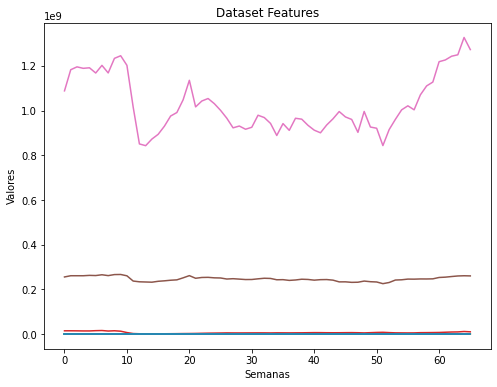

['flights', 'commercial_flights', 'People Screened at Airports', 'US International Commercial Flights', 'Nr People not staying home', 'Nr of trips', 'Temperature', 'Precipitation', 'Wind_Speed', 'Relative_Humidity']
Epoch 1/25
3/3 [==============================] - 1s 107ms/step - loss: 1.3706 - mae: 1.3288 - rmse: 1.3706 - val_loss: 0.8261 - val_mae: 0.8261 - val_rmse: 0.8261
Epoch 2/25
3/3 [==============================] - 0s 23ms/step - loss: 1.1187 - mae: 1.0761 - rmse: 1.1187 - val_loss: 0.8121 - val_mae: 0.8121 - val_rmse: 0.8121
Epoch 3/25
3/3 [==============================] - 0s 25ms/step - loss: 0.9183 - mae: 0.8715 - rmse: 0.9183 - val_loss: 0.7955 - val_mae: 0.7955 - val_rmse: 0.7955
Epoch 4/25
3/3 [==============================] - 0s 27ms/step - loss: 0.7458 - mae: 0.6922 - rmse: 0.7458 - val_loss: 0.7736 - val_mae: 0.7736 - val_rmse: 0.7736
Epoch 5/25
3/3 [==============================] - 0s 24ms/step - loss: 0.5973 - mae: 0.5336 - rmse: 0.5973 - val_loss: 0.7475 - val

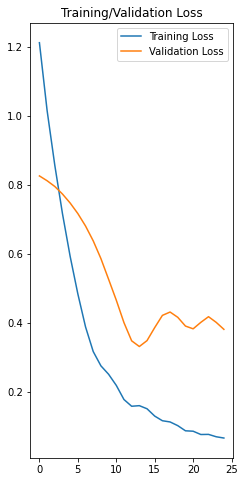

Epoch 1/25
6/6 [==============================] - 0s 20ms/step - loss: 0.2383 - mae: 0.2286 - rmse: 0.2714 - val_loss: 0.6298 - val_mae: 0.6157 - val_rmse: 0.6298
Epoch 2/25
6/6 [==============================] - 0s 9ms/step - loss: 0.1925 - mae: 0.1829 - rmse: 0.2177 - val_loss: 0.4849 - val_mae: 0.4656 - val_rmse: 0.4849
Epoch 3/25
6/6 [==============================] - 0s 10ms/step - loss: 0.1259 - mae: 0.1145 - rmse: 0.1387 - val_loss: 0.2814 - val_mae: 0.2456 - val_rmse: 0.2814
Epoch 4/25
6/6 [==============================] - 0s 12ms/step - loss: 0.0863 - mae: 0.0760 - rmse: 0.0936 - val_loss: 0.1611 - val_mae: 0.1288 - val_rmse: 0.1611
Epoch 5/25
6/6 [==============================] - 0s 12ms/step - loss: 0.0729 - mae: 0.0611 - rmse: 0.0796 - val_loss: 0.1726 - val_mae: 0.1286 - val_rmse: 0.1726
Epoch 6/25
6/6 [==============================] - 0s 11ms/step - loss: 0.0681 - mae: 0.0611 - rmse: 0.0729 - val_loss: 0.1736 - val_mae: 0.1217 - val_rmse: 0.1736
Epoch 7/25
6/6 [=======

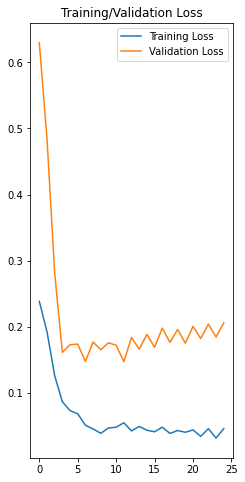

Epoch 1/25
8/8 [==============================] - 0s 15ms/step - loss: 0.0728 - mae: 0.0619 - rmse: 0.0728 - val_loss: 0.1860 - val_mae: 0.1479 - val_rmse: 0.1860
Epoch 2/25
8/8 [==============================] - 0s 8ms/step - loss: 0.0627 - mae: 0.0501 - rmse: 0.0627 - val_loss: 0.1625 - val_mae: 0.1330 - val_rmse: 0.1625
Epoch 3/25
8/8 [==============================] - 0s 7ms/step - loss: 0.0674 - mae: 0.0552 - rmse: 0.0674 - val_loss: 0.1348 - val_mae: 0.1082 - val_rmse: 0.1348
Epoch 4/25
8/8 [==============================] - 0s 7ms/step - loss: 0.0455 - mae: 0.0353 - rmse: 0.0455 - val_loss: 0.1382 - val_mae: 0.1082 - val_rmse: 0.1382
Epoch 5/25
8/8 [==============================] - 0s 8ms/step - loss: 0.0489 - mae: 0.0406 - rmse: 0.0489 - val_loss: 0.1345 - val_mae: 0.1021 - val_rmse: 0.1345
Epoch 6/25
8/8 [==============================] - 0s 7ms/step - loss: 0.0439 - mae: 0.0346 - rmse: 0.0439 - val_loss: 0.1378 - val_mae: 0.1113 - val_rmse: 0.1378
Epoch 7/25
8/8 [===========

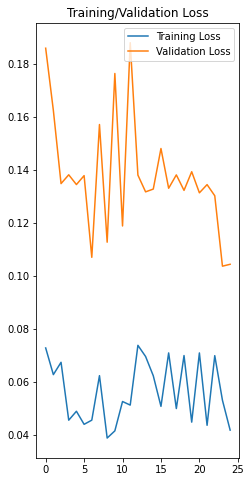

[[-0.93282443  0.50199153 -0.03958633 -0.17382996 -0.25412854  0.34715893
   0.55205722 -0.55895865 -0.05086739 -0.24137931  0.34657565]
 [-0.97862595  0.6534352   0.03735824 -0.03599208 -0.21781926  0.41672865
   0.58448907 -0.68044921 -0.81221209  0.52821317 -0.71065317]
 [-0.99083969  0.5701193   0.08157386  0.09707389 -0.20688272  0.5527526
   0.65319875 -0.13425217 -1.          0.44827586 -1.        ]
 [-0.97862595  0.58824001  0.11781633  0.15582335 -0.2081222   0.6751605
   0.68000488 -0.49770291 -0.81515241  0.11912226 -0.21950115]
 [-0.97557252  0.67726059  0.16553177  0.41773624 -0.19587328  0.7212234
   1.          0.05768249 -0.19768695 -0.11598746  0.38455566]
 [-1.          0.83914581  0.19440783  0.21715591 -0.18953009  0.68893163
   0.77609266 -0.29862175 -0.35705185  0.98119122 -0.50671282]]
1
Previsão:[[208.52083]]
[208.52083]


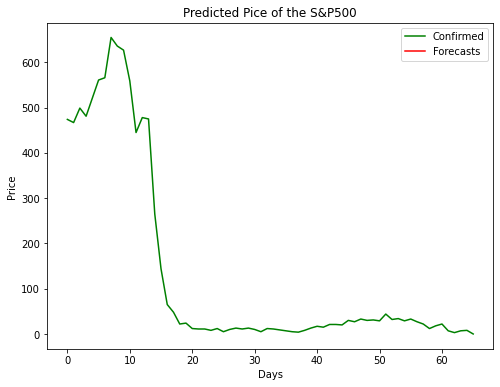

[array([[208.52083]], dtype=float32)]


In [165]:
################################
################################
########                ########
######## Main Execution ########
########                ########
################################
################################

n_variate = 4 #1, 2, 3  # number of features used by the model (using conf. cases to predict conf. cases) 

#the dataframes

df_raw = load_dataset('usa_dataset.csv')
df_data = prepare_data(df_raw)
df = df_data.copy()
n_variate = len(df.columns)
plot_confirmed_cases(df_data) #the plot you saw previously
scaler = data_normalization(df) #scaling data to [-1,1]


##Optimization

tunning_dict = {
                  1: {'timesteps' : 6, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 25,  'batch_size' : 5 }#,
                  #2: {'timesteps' : 7, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 50,  'batch_size' : 5 },
                  #3: {'timesteps' : 7, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 100,  'batch_size' : 5 },

                  #
                  #4: {'timesteps' : 8, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 60,  'batch_size' : 5 },
                  #5: {'timesteps' : 8, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 5 },
                  #6: {'timesteps' : 8, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 5 },
                  #
                  #7: {'timesteps' : 10, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 50,  'batch_size' : 8 },
                  #8: {'timesteps' : 10, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 8 },
                  #9: {'timesteps' : 10, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 8 }

  }
  # record da history de cada modelo
record = {}

#tunning the model cycle
for t in tunning_dict:
   # print(record[r])
   # fitting the model
   timesteps = tunning_dict[t]['timesteps']
   epochs = tunning_dict[t]['epochs']
   batch_size = tunning_dict[t]['batch_size']
   multisteps = tunning_dict[t]['multisteps']
   cv_splits = tunning_dict[t]['cv_splits']
   # print(timesteps,epochs,batch_size,cv_splits)

   X, y = to_supervised(df, timesteps)

   model = build_model(timesteps, n_variate)
   model, history = compile_and_fit(model, epochs, batch_size)
   # print("df: ",df.shape," timesteps",timesteps," multisteps ",multisteps)
   forecasts = forecast(model, df, timesteps, multisteps, scaler)
   plot_forecast(df_data, forecasts)
   print(forecasts)

   prev = []

   record[t] = history


  #Put the resulting metrics in a file
id_tunning = 1
id_split = 1

final_dict = {}

for r in record:
    # print(tunning_dict[1]['epochs'])
    loss = []
    mae = []
    rmse = []
    val_loss = []
    val_mae = []
    val_rmse = []

    for h in record[r]:
      # print("Tunning ID:  ",id_tunning," Split ID: ",id_split)
      # plot_learning_curves(h, tunning_dict[id_tunning]['epochs'])
      # ['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse']
      # print("loss: ",sum(h.history['loss'])/len(h.history['loss'])," MAE: ",sum(h.history['mae'])/len(h.history['mae'])," RMSE: ",sum(h.history['rmse'])/len(h.history['rmse'])," VAL_LOSS: ",sum(h.history['val_loss'])/len(h.history['val_loss'])," VAL_MAE: ",sum(h.history['val_mae'])/len(h.history['val_mae'])," VAL_RMSE: ",sum(h.history['val_rmse'])/len(h.history['val_rmse']))
      loss.append(sum(h.history['loss']) / len(h.history['loss']))
      mae.append(sum(h.history['mae']) / len(h.history['mae']))
      rmse.append(sum(h.history['rmse']) / len(h.history['rmse']))
      val_loss.append(sum(h.history['val_loss']) / len(h.history['val_loss']))
      val_mae.append(sum(h.history['val_mae']) / len(h.history['val_mae']))
      val_rmse.append(sum(h.history['val_rmse']) / len(h.history['val_rmse']))
      id_split += 1
    id_split = 1

    final_dict[id_tunning] = [sum(loss) / len(loss), sum(mae) / len(mae), sum(rmse) / len(rmse),
                              sum(val_loss) / len(val_loss), sum(val_mae) / len(val_mae), sum(val_rmse) / len(val_rmse)]

    id_tunning = id_tunning + 1




In [166]:
for f in final_dict:
    print("Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE")
    print("ID tunning: ",f, " Valores: ",final_dict[f],"\n")

final_df = pd.DataFrame.from_dict(final_dict, orient='index')
final_df.columns = ['Loss','MAE','RMSE','VAL_LOSS','VAL_MAE','VAL_RMSE']
final_df

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  1  Valores:  [0.14560885613163313, 0.1325164938221375, 0.1468922953804334, 0.2906470348437627, 0.2770110524694125, 0.29064703444639844] 



,Loss,MAE,RMSE,VAL_LOSS,VAL_MAE,VAL_RMSE
1,0.145609,0.132516,0.146892,0.290647,0.277011,0.290647


In [167]:
#Results metrics to a file
final_df.to_csv(r"resultados_cnn_covid.csv",index=True)